# Gaussian Filtering
In the following, you will implement a method which generates and applies a Gaussian filter for a given variance and number of samples.

In [12]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

## Some convenience functions

In [13]:
def imread_rgb(filename):
    """Read a color image from our data directory."""
    im = cv2.imread(f'../data/{filename}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im


def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

## Part a
Start by writing a function ``gauss`` which creates a 1D Gaussian from a given vector of integer indices $\mathtt{x = [-w, \ldots, w]}$:
$$
    \mathtt{G[i]} = \frac{1}{\sqrt{2\pi}\sigma}\operatorname{exp}\biggl(-\frac{\mathtt{x[i]}^2}{2\sigma^2}\biggr)
$$
where $\sigma$ is the standard deviation.

In [14]:
def gauss(x, sigma):
    # Your code here
    x = np.exp(-np.power(x, 2.0) / (2 * np.power(sigma, 2.0))) / (sigma * np.sqrt(2 * np.pi))
    return x

100


<IPython.core.display.Javascript object>


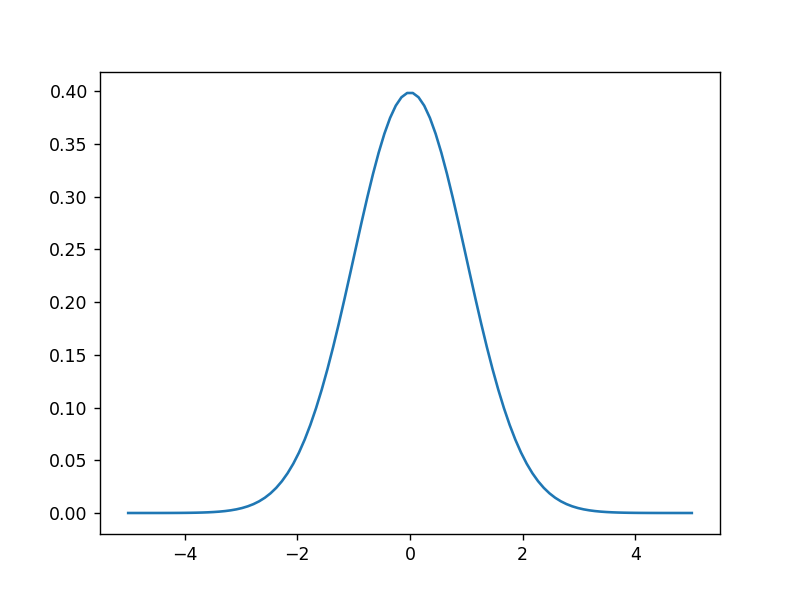

In [15]:
x = np.linspace(-5, 5, 100)
y = gauss(x, 1.0)
print(len(y))
fig, ax = plt.subplots()
ax.plot(x, y)

## Part b
Use the above function to implement a function `gaussian_filter(image, sigma, padding)`, which first generates a Gaussian filter and then applies it to the `image`.
The size of the filter should be $2 \cdot \lceil 3 \sigma \rceil + 1$.
Remember that the Gaussian is separable, *i.e.* that an equivalent 2D result can be obtained through a sequence of two 1D filtering operations.
Do not use any existing implementation for convolution in this part (e.g. `scipy.ndimage.convolve`).
However, you are allowed to use these implementations in the following questions.

In [16]:
from PIL import Image

def plot_single(x):
    img = Image.fromarray(x)
    img.show()

In [24]:
def zero_pad(image, pad_w, pad_h):
    
    """
    Adds zero padding to the image so that we retain the image size.
    """
    img_w, img_h = image.shape
    
    ret = np.zeros((img_w + 2*pad_w, img_h + 2*pad_h))
    
    ret[pad_w:img_w+pad_w, pad_h:img_h+pad_h] = image
    
    return ret
    

In [23]:
def img_convolve2d(kernel, image):
    
    """
    Convolution operation implementation using numpy.
    
    """
    #plot_single(image)
    
    img_w, img_h = image.shape
    ker_w, ker_h = kernel.shape
    
    res = np.zeros((img_w, img_h))
    
    image = zero_pad(image, (ker_w-1)//2, (ker_h-1)//2)
    
    kernel = np.flip(kernel, 0)
    kernel = np.flip(kernel, 1)
    
    for m in range(img_w):
        for n in range(img_h):
            res[m,n] = np.sum(image[m : m+ker_w, n: n+ker_h] * kernel)
    
    
    return res


In [25]:
def img_convolve(kernel, image):
    
    """
        Performing 2D convolution across the RGB channels and then stacking them into one single np array.
    
    """
    
    img_height, img_width, img_channels = image.shape
    ker_height, ker_width = kernel.shape
    #print(image[:, :, 0].shape)
    
    
    ims = []
    for channel in range(img_channels):
        temp_res = img_convolve2d(kernel, image[:, :, channel])
        #plot_single(temp_res)
        #print(temp_res.shape)
        ims.append(temp_res)
          
    img_convolved = np.stack(ims, axis=2).astype('uint8')
    
    return img_convolved

In [26]:
def gaussian_filter(image, sigma, padding=True):
    # Your code here
    x = np.arange(-3*sigma, 3*sigma + 1)
    y = np.arange(-3*sigma, 3*sigma + 1)
    #print(x.shape)
    x = gauss(x, sigma)
    y = gauss(y, sigma)
    kernel = np.outer(x, y)
    kernel = kernel / np.sum(kernel)
    #print(kernel.shape)
    image = img_convolve(kernel, image)
    return image

Read the image ``graf_small.png`` and apply the filters with ``sigma = 2``, ``4``, and ``8``.
Again, choose the kernel size as $2 \cdot \lceil 3 \sigma\rceil + 1$.
What do you observe?

<IPython.core.display.Javascript object>


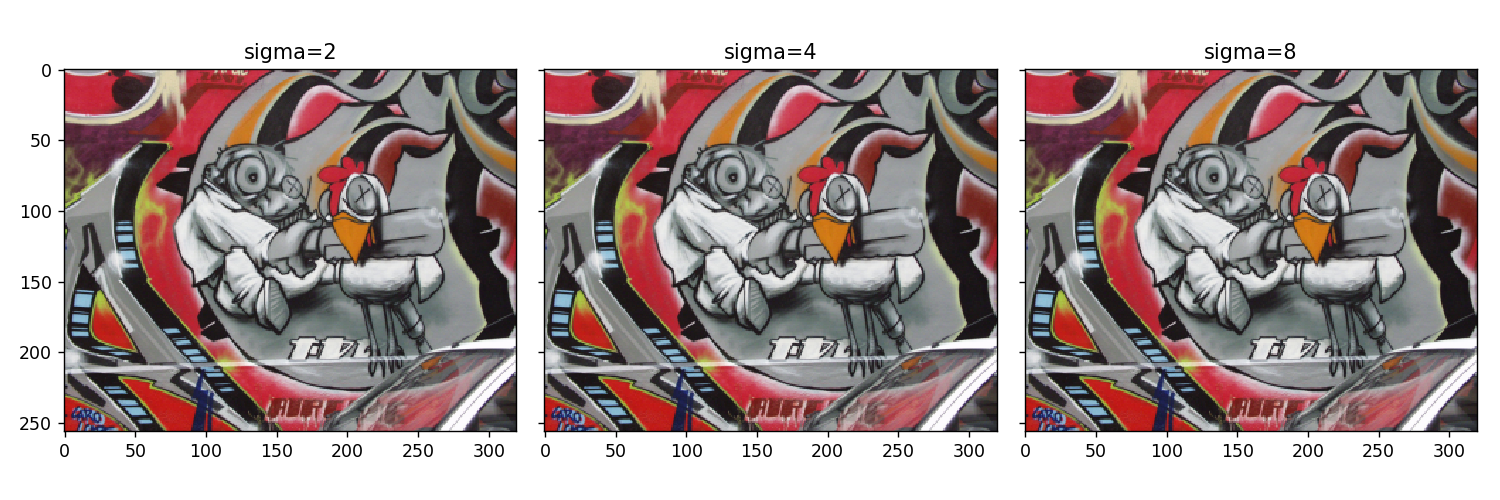

<IPython.core.display.Javascript object>


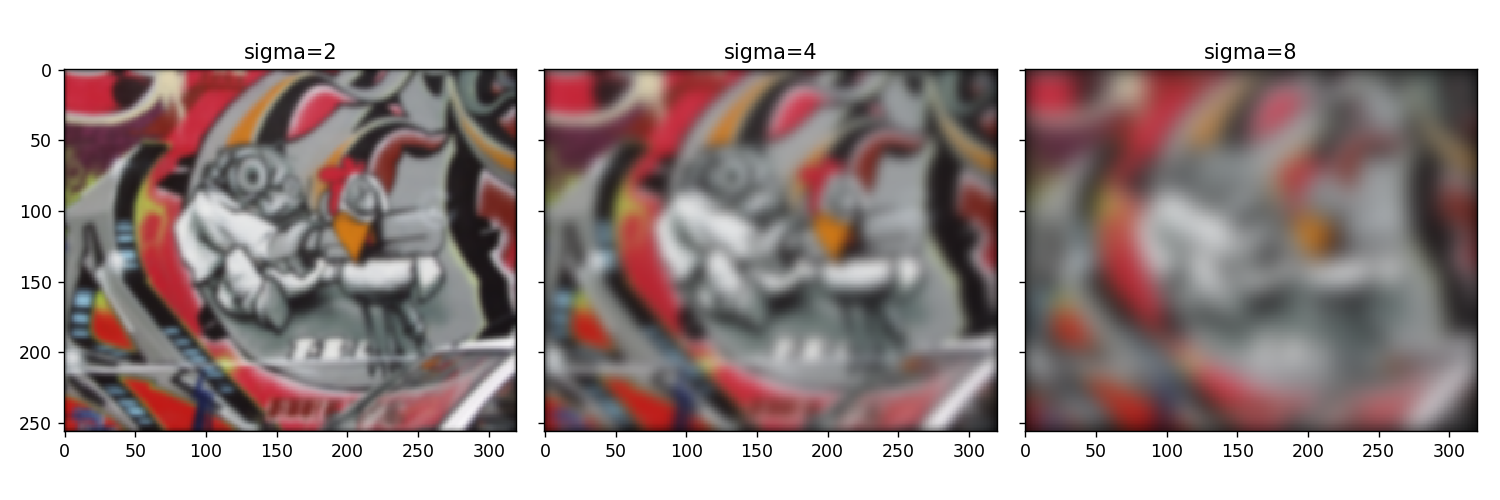

In [27]:
image = imread_rgb('graf_small.png')
#print(image.shape)
sigmas = [2, 4, 8]
original_images = [image, image, image]
blurred_images = [gaussian_filter(image, s) for s in sigmas]
titles = [f'sigma={s}' for s in sigmas]
plot_multiple(original_images, titles)
plot_multiple(blurred_images, titles)

**What do you observe? Type your answer here:**

----

OpenCV has many built-in function for image smoothing.
Check out this page:
https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html

Compare the result of ``cv2.GaussianBlur`` with your own implementation by computing the difference image.
Was your implementation correct?

<IPython.core.display.Javascript object>


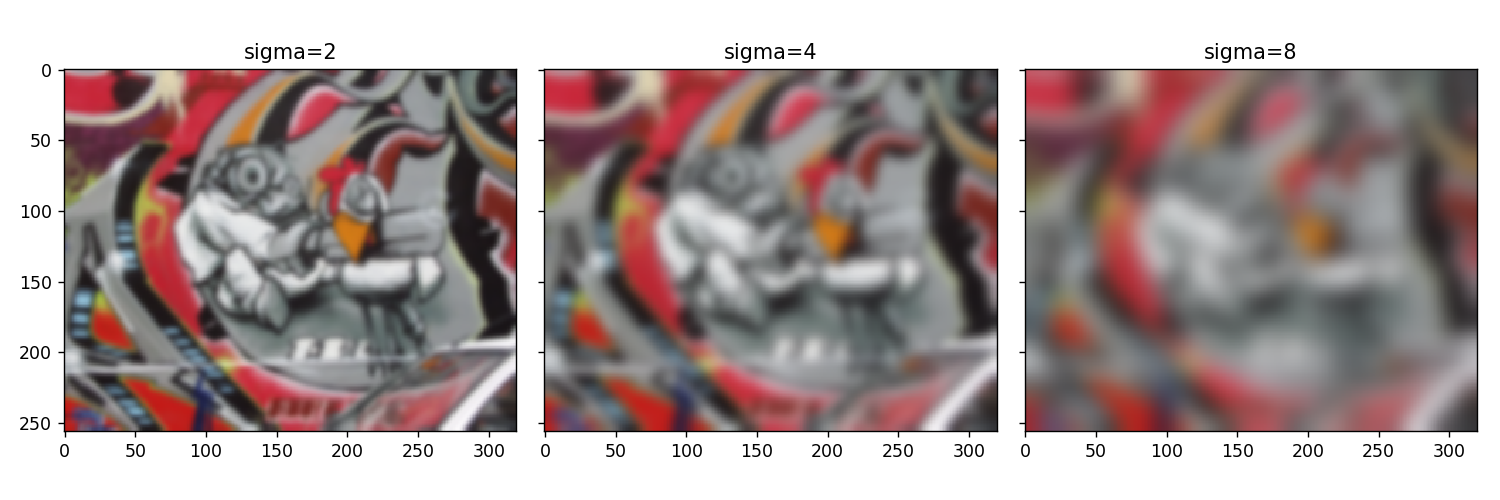

<IPython.core.display.Javascript object>


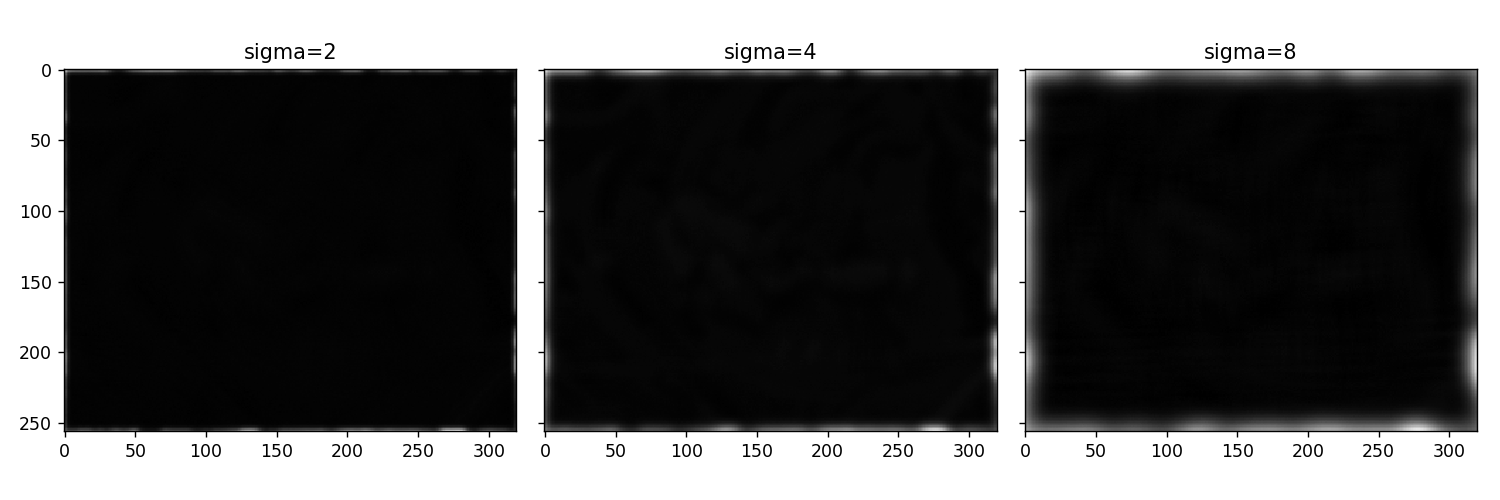

In [28]:
def gauss_cv(image, sigma):
    ks = 2 * int(3 * sigma) + 1
    return cv2.GaussianBlur(image, (ks, ks), sigma, cv2.BORDER_DEFAULT)

def abs_diff(image1, image2):
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    return np.mean(np.abs(image1-image2), axis=-1)

blurred_images_cv = [gauss_cv(image, s) for s in sigmas]
differences = [abs_diff(x,y) for x, y in zip(blurred_images, blurred_images_cv)]

plot_multiple(blurred_images_cv, titles)
plot_multiple(differences, titles)

**Was your implementation correct? What do you observe? Type your answer here:**

----